In [48]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

### Cargue de datos

In [2]:
# Cargar los datos
df = pd.read_csv("D:\\visualization\\formula1\\data\\processed\\df_train_v3.csv")

# Preprocesamiento de datos
df['ds'] = pd.to_datetime(df['race_date']).dt.to_period('M').dt.to_timestamp()
df['ds'] = pd.to_datetime(df['ds'])
df['prob_ganar'] = np.where(df['final_position'] == 1, 1, 0)

# Imputar valores faltantes con la mediana por columna
df = df.fillna(df.median(numeric_only=True))

# Agrupar por piloto y fecha
df = df.groupby(['driverId', 'ds']).agg({
    'prob_ganar': 'mean',
    'fastest_lap': 'mean',
    'driver_points': 'mean',
    'completed_laps': 'mean',
    'fastest_lap_speed': 'mean',
    'qualifying_position': 'mean',
    'driver_standing_points': 'mean',
    'constructor_points': 'mean',
    'constructor_wins': 'mean'
}).reset_index()

### Entrenamiento de modelo prophet

In [16]:
# Diccionario para almacenar modelos y predicciones por piloto
modelos = {}
resultados_predicciones = []

# Iterar sobre cada piloto
for piloto in df['driverId'].unique():
    # Filtrar datos para el piloto actual
    df_piloto = df[df['driverId'] == piloto][['ds', 'prob_ganar', 
                                               'fastest_lap', 'driver_points', 'completed_laps',
                                               'fastest_lap_speed', 'qualifying_position',
                                               'driver_standing_points', 'constructor_points', 'constructor_wins']]
    
    # Renombrar 'prob_ganar' a 'y' para Prophet
    df_piloto = df_piloto.rename(columns={'prob_ganar': 'y'})
    
    # Verificar si hay al menos 2 filas no nulas en la columna 'y'
    if df_piloto['y'].notnull().sum() < 2:
        continue  # Saltar al siguiente piloto
    
    # Crear y configurar el modelo Prophet con regresores
    modelo = Prophet()
    for regressor in ['fastest_lap', 'driver_points', 'completed_laps', 'fastest_lap_speed',
                      'qualifying_position', 'driver_standing_points', 'constructor_points', 'constructor_wins']:
        modelo.add_regressor(regressor)
    
    # Entrenar el modelo
    modelo.fit(df_piloto)
    modelos[piloto] = modelo
    
    # Crear un DataFrame de fechas futuras hasta diciembre de 2024
    future = modelo.make_future_dataframe(periods=12, freq='M')
    future = future[future['ds'] <= '2024-12-31']
    
    # Añadir los valores de los regresores al DataFrame de fechas futuras
    future = future.merge(df_piloto[['ds', 'fastest_lap', 'driver_points', 'completed_laps',
                                     'fastest_lap_speed', 'qualifying_position',
                                     'driver_standing_points', 'constructor_points', 'constructor_wins']],
                          on='ds', how='left')
    
    # Rellenar nuevamente los valores nulos después del merge
    future = future.fillna(df_piloto.median(numeric_only=True))
    
    # Verificación adicional para confirmar que no haya valores nulos en future
    if future.isnull().values.any():
        continue  # Saltar al siguiente piloto
    
    # Generar predicciones para el futuro
    forecast = modelo.predict(future)
    
    # Filtrar solo las predicciones para diciembre de 2024 usando mes y año
    forecast_diciembre_2024 = forecast[(forecast['ds'].dt.year == 2024) & (forecast['ds'].dt.month == 12)]
    
    # Verificar si hay predicciones para diciembre de 2024
    if forecast_diciembre_2024.empty:
        continue
    
    forecast_diciembre_2024['driverId'] = piloto  # Agregar el ID del piloto
    
    # Guardar la predicción en la lista de resultados
    resultados_predicciones.append(forecast_diciembre_2024[['ds', 'yhat', 'driverId']])

# Combinar todas las predicciones en un solo DataFrame y ordenar por probabilidad de ganar
predicciones_totales = pd.concat(resultados_predicciones, ignore_index=True)
predicciones_totales = predicciones_totales.sort_values(by='yhat', ascending=False).reset_index(drop=True)


19:43:14 - cmdstanpy - INFO - Chain [1] start processing
19:43:14 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\cris_\anaconda3\envs\modelo_formula1\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
C:\Users\cris_\AppData\Local\Temp\ipykernel_25468\2957406103.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_diciembre_2024['driverId'] = piloto  # Agregar el ID del piloto
c:\Users\cris_\anaconda3\envs\modelo_formula1\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
19:43:14 - cmdstanpy - I

In [17]:
predicciones_totales

,ds,yhat,driverId
0,2024-12-31,5.140886,846
1,2024-12-31,4.426892,844
2,2024-12-31,2.271836,839
3,2024-12-31,0.843665,847
4,2024-12-31,0.070796,1
5,2024-12-31,0.000000,860
6,2024-12-31,0.000000,859
7,2024-12-31,0.000000,858
8,2024-12-31,0.000000,855
9,2024-12-31,0.000000,852


### Normalización de probabilidades

Min Max

In [22]:
predicciones_totales_min_max = predicciones_totales.copy(deep = True)

In [30]:
predicciones_totales_min_max['yhat'] = predicciones_totales_min_max['yhat'].abs()
yhat_min = predicciones_totales_min_max['yhat'].min()
yhat_max = predicciones_totales_min_max['yhat'].max()
predicciones_totales_min_max['probabilidad_ganar'] = ((predicciones_totales_min_max['yhat'] - yhat_min) / (yhat_max - yhat_min)).round(4)


In [52]:
predicciones_totales_min_max['probabilidad_ganar'] = ((predicciones_totales_min_max['yhat'] - yhat_min) / (yhat_max - yhat_min)).pow(0.5).round(3)


In [56]:
predicciones_totales_min_max.sort_values(by = 'probabilidad_ganar',ascending=False)

,ds,yhat,driverId,probabilidad_ganar
22,2024-12-31,18.097690,830,1.000
21,2024-12-31,6.650734,832,0.606
0,2024-12-31,5.140886,846,0.533
1,2024-12-31,4.426892,844,0.495
2,2024-12-31,2.271836,839,0.354
20,2024-12-31,1.308449,842,0.269
3,2024-12-31,0.843665,847,0.216
19,2024-12-31,0.079529,4,0.066
4,2024-12-31,0.070796,1,0.063
18,2024-12-31,0.039249,857,0.047


Text(0.5, 1.0, 'Normalización min max')

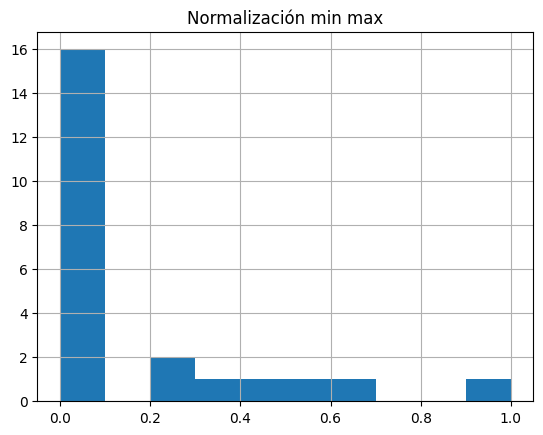

In [57]:
predicciones_totales_min_max.probabilidad_ganar.hist()
plt.title('Normalización min max')

### Asignación de nombres

In [8]:
import mysql.connector

In [9]:
# Conexión a la base de datos MySQL
conn = mysql.connector.connect(
    host='localhost',       # Dirección del servidor MySQL (puede ser localhost si es local)
    user='root',            # Usuario de MySQL (ajusta según tu configuración)
    password='Ringochunin1302',  # Contraseña de MySQL
    database='ergast_f1'    # Nombre de la base de datos
)


# Crear un cursor para ejecutar la consulta
cursor = conn.cursor()

In [10]:
# Ejecutar la consulta para obtener los años disponibles
query = """
SELECT 
    d.driverId,
    d.forename AS driver_first_name,
    d.surname AS driver_last_name,
    c.constructorId,
    c.name AS constructor_name
FROM 
    drivers d
JOIN 
    results r ON d.driverId = r.driverId
JOIN 
    constructors c ON r.constructorId = c.constructorId
JOIN 
    races ra ON r.raceId = ra.raceId
WHERE 
    ra.year = (SELECT MAX(year) FROM races)  -- Filtrar para el año más reciente
GROUP BY 
    d.driverId, d.forename, d.surname, c.constructorId, c.name
ORDER BY 
    d.driverId;

"""


In [11]:
%%time
cursor.execute(query)

# Obtener los resultados y convertirlos en un DataFrame de pandas
result = cursor.fetchall()

# Obtener los nombres de las columnas
columns = [i[0] for i in cursor.description]

# Convertir los resultados en un DataFrame
df_names = pd.DataFrame(result, columns=columns)

# Cerrar el cursor y la conexión
cursor.close()
conn.close()

CPU times: total: 0 ns
Wall time: 568 ms


In [12]:
df_names['name'] = df_names.driver_first_name + ' ' + df_names.driver_last_name + ' - ' + df_names.constructor_name

In [13]:
df_names

,driverId,driver_first_name,driver_last_name,constructorId,constructor_name,name
0,1,Lewis,Hamilton,131,Mercedes,Lewis Hamilton - Mercedes
1,4,Fernando,Alonso,117,Aston Martin,Fernando Alonso - Aston Martin
2,807,Nico,Hülkenberg,210,Haas F1 Team,Nico Hülkenberg - Haas F1 Team
3,815,Sergio,Pérez,9,Red Bull,Sergio Pérez - Red Bull
4,817,Daniel,Ricciardo,215,RB F1 Team,Daniel Ricciardo - RB F1 Team
5,822,Valtteri,Bottas,15,Sauber,Valtteri Bottas - Sauber
6,825,Kevin,Magnussen,210,Haas F1 Team,Kevin Magnussen - Haas F1 Team
7,830,Max,Verstappen,9,Red Bull,Max Verstappen - Red Bull
8,832,Carlos,Sainz,6,Ferrari,Carlos Sainz - Ferrari
9,839,Esteban,Ocon,214,Alpine F1 Team,Esteban Ocon - Alpine F1 Team


In [58]:
df_prediction = pd.merge(predicciones_totales_min_max,df_names[['driverId','name']],how = 'left', on='driverId')[['name','probabilidad_ganar']]

In [66]:
df_prediction = df_prediction.sort_values(by = 'probabilidad_ganar',ascending=False).reset_index(drop=True)
df_prediction['posicion'] = range(1, len(df_prediction) + 1)

In [67]:
df_prediction

,name,probabilidad_ganar,posicion
0,Max Verstappen - Red Bull,1.000,1
1,Carlos Sainz - Ferrari,0.606,2
2,Lando Norris - McLaren,0.533,3
3,Charles Leclerc - Ferrari,0.495,4
4,Esteban Ocon - Alpine F1 Team,0.354,5
5,Pierre Gasly - Alpine F1 Team,0.269,6
6,George Russell - Mercedes,0.216,7
7,Fernando Alonso - Aston Martin,0.066,8
8,Lewis Hamilton - Mercedes,0.063,9
9,Oscar Piastri - McLaren,0.047,10


In [68]:
# Usar doble barra invertida en la ruta
df_prediction.to_csv("D:\\visualization\\formula1\\data\\processed\\df_prediction.csv", index=False)